Repetir o gráfico:
- Categorias que vendem mais em cada mês.
usando o clip(0,20)

A linha que monta a entrada da LSTM

In [1]:
#a = df_clean[['date_block_num', 'shop_id', 'item_id','city_code', 'revenue', 'item_cnt_day']]
#a.pivot_table(index=['shop_id', 'item_id', 'city_code'], columns=['date_block_num'], values=['item_cnt_day','revenue'], aggfunc='sum', fill_value=0).stack()[0:33]

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Sequential

from sklearn.metrics import mean_squared_error

path = 'data'

train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz').set_index('ID')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')
geo = pd.read_csv(path + '/geo_shop.csv')

In [4]:
df_train_month = pd.read_pickle('df_train_month_lag6.pkl')

df_train_month.head()

,shop_id,item_id,date_block_num,item_cnt_month_lag(-1),item_cnt_month_lag(-2),item_cnt_month_lag(-3),item_cnt_month_lag(-4),item_cnt_month_lag(-5),item_cnt_month_lag(-6),item_cnt_month_lag(0),...,revenue_month_lag(-5),revenue_month_lag(-6),revenue_month_lag(0),item_category_id,type_code,subtype_code,city_code,latitude,longitude,is_online
6,0,30,6,0,0,0,0,31,0,0,...,8215.0,0.0,0.0,40,11,4,29,62.035454,129.675476,0
7,0,30,7,0,0,0,0,0,31,0,...,0.0,8215.0,0.0,40,11,4,29,62.035454,129.675476,0
8,0,30,8,0,0,0,0,0,0,0,...,0.0,0.0,0.0,40,11,4,29,62.035454,129.675476,0
9,0,30,9,0,0,0,0,0,0,0,...,0.0,0.0,0.0,40,11,4,29,62.035454,129.675476,0
10,0,30,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,40,11,4,29,62.035454,129.675476,0


In [ ]:
def fit_column_scaler_min_max(minval, maxval, dataframe):
    
    columns = dataframe.columns
    
    scaler = { column : MinMaxScaler(feature_range=(minval, maxval))
              for column in columns}
    
    scaler_fit = [scaler[column].fit_transform(dataframe[[column]])
                  for column in columns]
    
    for idx, column in enumerate(columns):
        dataframe[column] = scaler_fit[idx]
        
    return dataframe, scaler

In [ ]:
def inv_column_scaler_min_max(scaler_data, dataframe):
    
    columns = dataframe.columns
    
    scaler_inv = [scaler_data[column].inverse_transform(dataframe[[column]])
                  for column in columns]
        
    for idx, column in enumerate(columns):
        dataframe[column] = scaler_inv[idx]
        
    return dataframe

In [ ]:
df_train_month, scaler = fit_column_scaler_min_max(0, 1, df_month)

In [5]:
t = df_train_month['date_block_num']
time_steps = t.max() - t.min()

del t

In [6]:
features = df_train_month.shape[1] - 2 # date_block_num e item_cnt_lag(0) não vão entrar.
n_samples = int(df_train_month.shape[0] / (time_steps + 1) ) # +1 é porque ainda não retirei o mês 33

'Time:', time_steps, 'Features:', features, 'Samples:', n_samples

('Time:', 27, 'Features:', 57, 'Samples:', 424124)

In [7]:
x_train = df_train_month[df_train_month.date_block_num != 33].drop(['date_block_num', 'item_cnt_month_lag(0)'], axis=1).values
y_train = df_train_month.loc[df_train_month.date_block_num == 33, 'item_cnt_month_lag(0)'].values

In [8]:
x_train = x_train.reshape((n_samples, time_steps, features))

In [9]:
x_train.shape, y_train.shape

((424124, 27, 57), (424124,))

In [11]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(time_steps, features)))#, return_sequences=True))
model.add(Dropout(0.5))
#model.add(LSTM(units=64, input_shape=(time_step1, features1)))
#model.add(Dropout(0.5))
model.add(Dense(1))

In [12]:
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                11520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train, y_train, batch_size = 4096, epochs = 10, shuffle=False)

Epoch 1/10
424124/424124 [==============================] - 23s 55us/step - loss: 16.3354 - mean_squared_error: 16.3354
Epoch 2/10
424124/424124 [==============================] - 22s 51us/step - loss: 16.1323 - mean_squared_error: 16.1323
Epoch 3/10
424124/424124 [==============================] - 22s 53us/step - loss: 16.0567 - mean_squared_error: 16.0567
Epoch 4/10
424124/424124 [==============================] - 22s 52us/step - loss: 16.0313 - mean_squared_error: 16.0313
Epoch 5/10
424124/424124 [==============================] - 22s 51us/step - loss: 16.0342 - mean_squared_error: 16.0342
Epoch 6/10
424124/424124 [==============================] - 23s 54us/step - loss: 16.0222 - mean_squared_error: 16.0222
Epoch 7/10
424124/424124 [==============================] - 22s 53us/step - loss: 16.0279 - mean_squared_error: 16.0279
Epoch 8/10
424124/424124 [==============================] - 22s 52us/step - loss: 16.0181 - mean_squared_error: 16.0181
Epoch 9/10
424124/424124 [==============

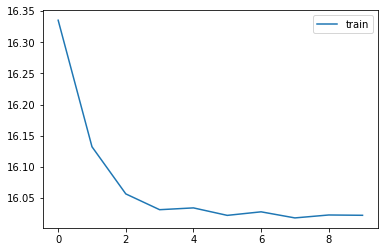

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history[''], label='train')
plt.legend()
plt.show()

In [23]:
#pred = df_train_month[df_train_month.date_block_num != 6].drop(['date_block_num', 'item_cnt_month_lag(0)'], axis=1).values
#pred = pred.reshape((n_samples, time_steps, features))
#yhat = model.predict(pred)

In [27]:
#rmse = np.sqrt(mean_squared_error(y_train, yhat))
#print('Test RMSE: %.3f' % rmse) #0.565

Test RMSE: 3.993
